# **Vanilla Policy Gradient & Introducing OpenAI Gym**

Environment: Lunar Lander

## References

#### Papers
- [High-Dimensional Continuous Control Using Generalized Advantage Estimation, Schulman et al, 2015. Algorithm: GAE.](https://arxiv.org/abs/1506.02438)

#### Blogs
- [OpenAI Spinning Up - Vanilla Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/vpg.html)

#### Others
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html)
- [OpenAI Gym](https://gym.openai.com/)
- [李宏毅 (Hung-yi Lee) - Deep Learning for Human Language Processing (2020,Spring)](http://speech.ee.ntu.edu.tw/~tlkagk/courses_ML20.html)

## Preparation

> First, we need to install required system packages as well as PyPi packages. "Gym" is a package provided by OpenAI as a toolkit for developing reinforcement learning algorithm. Other packages are used for visualization in Notebook.



In [1]:
#'''
%%capture
!sudo apt update
!sudo apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay piglet tqdm
#'''

> Next, we need to import required packages and set up virtual display.



In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm_notebook

> Finally, import gym and create a [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment

In [3]:
%%capture
import gym
env = gym.make('LunarLander-v2')

### Lunar Lander
Lunar Lander is an environment simulates the process of lunar module landing on the moon. [(Source code)](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)

> Let us check the contents of obervation/state, action and reward provieded by the environment.

In [4]:
'''
# Observation/State
print("Observation/State: {}".format(env.observation_space))

# Action
print("Action: {}".format(env.action_space))

# Sample an action to get reward
initial_state = env.reset() # Get initial state
#print("State(initial): {}".format(initial_state))
random_action = env.action_space.sample() # Sample an action
# Reward
observation, reward, done, info = env.step(random_action)
print("Reward: {}".format(reward))
'''

'\n# Observation/State\nprint("Observation/State: {}".format(env.observation_space))\n\n# Action\nprint("Action: {}".format(env.action_space))\n\n# Sample an action to get reward\ninitial_state = env.reset() # Get initial state\n#print("State(initial): {}".format(initial_state))\nrandom_action = env.action_space.sample() # Sample an action\n# Reward\nobservation, reward, done, info = env.step(random_action)\nprint("Reward: {}".format(reward))\n'

> The observation/state is an 8 dimension vector includes 


#### Demo: Random Agent
Here we randomly sample an action from the action space of the environment.

In [5]:
'''
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
'''

"\nenv.reset()\n\nimg = plt.imshow(env.render(mode='rgb_array'))\n\ndone = False\nwhile not done:\n    action = env.action_space.sample()\n    observation, reward, done, info = env.step(action)\n\n    img.set_data(env.render(mode='rgb_array'))\n    display.display(plt.gcf())\n    display.clear_output(wait=True)\n"

## VPG Algorithm
Vanilla Policy Gradient (also called REINFORCE, Monte-Carlo policy gradient)

We implement simple VPG with simple discounted rewards.

\begin{equation}
\begin{split}
&\hat{g}_k = \frac{1}{\lvert{\mathcal{D}_k}\rvert} \sum_{\tau\in\mathcal{D}_k} \sum_{t=0}^{T} \nabla_\theta\ log \ \pi_{\theta}(a_t|s_t) |_{\theta_k} \hat{A}_t
\end{split}
\end{equation}

### Pseudocode



### Policy Gradient Network
> First, we build an simple policy network with input dimension 8 and output dimension 4.



In [6]:
class PGNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        #self.fc3 = nn.Linear(32, 32)
        #self.fc4 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        hid = torch.tanh(self.fc3(hid))
        return F.softmax(self.fc4(hid), dim=-1)

### Value Function Network

In [7]:
class VFNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        #self.fc3 = nn.Linear(32, 32)
        #self.fc4 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        hid = torch.tanh(self.fc3(hid))
        #hid = torch.tanh(self.fc4(hid))
        #hid = torch.tanh(self.fc5(hid))
        return self.fc4(hid)

### Compute Discounted Reward

> Here we use simple discounted reward $\sum_{l=0}^\infty \gamma^l r_{t+l}$ for example.


In [8]:
# Compute discounted Reward
def discount_cumsum(eps_reward, gamma):
    for i in reversed(range(len(eps_reward))):
        if (i+1) < len(eps_reward):
            eps_reward[i] = eps_reward[i] + gamma*eps_reward[i+1]

    return eps_reward

### Vanilla Policy Gradient Agent
> Next, we build an simple agent which use the policy network above to take action and have the following functions:
1.   `update_pgnet()`: Update the policy network with log probabilities and rewards.
2.   `learn_vfnet()`: Update the value function network.
3.   `sample()`: Sample an action and return the log probabilities by the policy network with the observation from the environment.


In [9]:
class PGAgent():

    def __init__(self, pgnet, vfnet):
        self.pgnet = pgnet
        self.vfnet = vfnet
        self.pg_optimizer = optim.Adam(self.pgnet.parameters(), lr=0.0003)
        self.vf_optimizer = optim.Adam(self.vfnet.parameters(), lr=0.001)

    def update_pgnet(self, log_probs, states, advs, EPISODE_PER_BATCH):
        advs = (advs - torch.mean(advs)) / torch.std(advs) #+ 1e-9
        loss = (-log_probs * advs).mean() #.sum() /EPISODE_PER_BATCH

        self.pg_optimizer.zero_grad()
        loss.backward()
        self.pg_optimizer.step()

        return loss.item()

    def learn_vfnet(self, states, rewards_to_go, train_v_iters):
        loss_vfnet = []
        for i in range(train_v_iters):
            value_estimates = self.vfnet(torch.FloatTensor(states))
            loss = ((value_estimates-rewards_to_go)**2).mean()

            self.vf_optimizer.zero_grad()
            loss.backward()
            self.vf_optimizer.step()

            loss_vfnet.append(loss.item())
        
        return loss_vfnet

    def sample(self, state):
        action_prob = self.pgnet(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

### Train

In [10]:
pgnet = PGNet()
vfnet = VFNet()
agent = PGAgent(pgnet, vfnet)

In [11]:
agent.pgnet.train()
agent.vfnet.train()

EPISODE_PER_BATCH = 50  # Update agent once per EPISODE_PER_BATCH episodes.
NUM_BATCH = 50          # Update agent NUM_BATCH times in total.
gamma = 0.999           # Discount parameter.
train_v_iters = 80      # Number of gradient descent steps to take on value function per BATCH.

avg_total_rewards, avg_final_rewards = [], []

# Analyze
loss_pgnet, loss_vfnet = [], []
ret_raw, ret_norm, log_probs_all, actions = [], [], [], []

prg_bar = tqdm_notebook(range(NUM_BATCH))
for batch in prg_bar:

    log_probs = []
    total_rewards, final_rewards = [], []

    discounted_rewards = []
    states = []
    advs = []

    # Collecting training data
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        episode_reward = []
        episode_state = []
        episode_actions = []
        episode_log_probs = []

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            episode_state.append(state)
            state = next_state
            total_reward += reward
            #total_step += 1

            # Analyze
            episode_reward.append(reward)
            episode_actions.append(action)
            episode_log_probs.append(log_prob.item())

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                                
                discounted_reward = discount_cumsum(episode_reward, gamma)
                discounted_rewards.append(discounted_reward)
                states.append(episode_state)

                # Compute GAE-Lambda
                vals = np.concatenate(agent.vfnet(torch.FloatTensor(episode_state)).detach().numpy(), axis=0)
                deltas = np.asarray(episode_reward[:-1]) + gamma*vals[1:] - vals[:-1]
                deltas = np.append(deltas, episode_reward[-1] - vals[-1])
                adv = discount_cumsum(deltas, gamma*0.97)
                #advs.append(adv)
                advs.append(deltas)
                break

    # Log training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    actions.append(np.array(episode_actions))

    # Update Policy Gradient Network
    discounted_rewards = np.concatenate(discounted_rewards, axis=0)
    states = np.concatenate(states, axis=0)

    # Analyze
    ret_raw.append(discounted_rewards)
    log_probs_all.append(np.array(episode_log_probs))
    
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / np.std(discounted_rewards) + 1e-9
    ret_norm.append(discounted_rewards)

    advs = np.concatenate(advs, axis=0)

    #agent.update_pgnet(torch.stack(log_probs), torch.from_numpy(discounted_rewards), EPISODE_PER_BATCH)
    #agent.update_pgnet(torch.stack(log_probs), discounted_rewards, EPISODE_PER_BATCH)
    loss_pgnet.append(agent.update_pgnet(torch.stack(log_probs), states, torch.from_numpy(advs), EPISODE_PER_BATCH))
    loss_vfnet.append(agent.learn_vfnet(states, torch.from_numpy(discounted_rewards), train_v_iters))


loss_pgnet = np.array(loss_pgnet)
loss_vfnet = np.array(loss_vfnet)
loss_vfnet = np.concatenate(loss_vfnet, axis=0)
actions = np.concatenate(actions, axis=0)
ret_raw = np.concatenate(ret_raw, axis=0)
ret_norm = np.concatenate(ret_norm, axis=0)
log_probs_all = np.concatenate(log_probs_all, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [12]:
discounted_rewards

array([-0.30394573, -0.27709969, -0.25545944, ...,  1.0353788 ,
        0.9136473 ,  0.33807163])

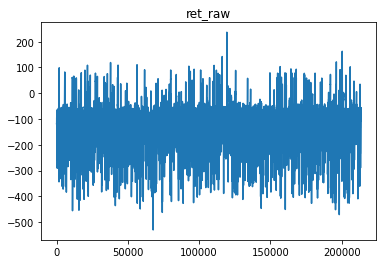

In [13]:
plt.plot(ret_raw)
plt.title("ret_raw")
plt.show()

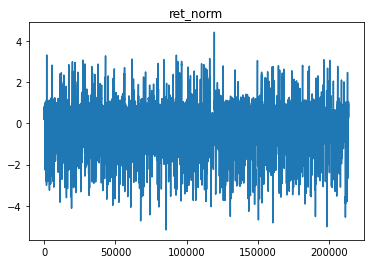

In [14]:
plt.plot(ret_norm)
plt.title("ret_norm")
plt.show()

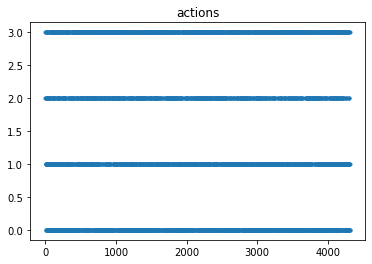

In [15]:
plt.plot(actions, 'o', markersize=3)
plt.title("actions")
plt.show()

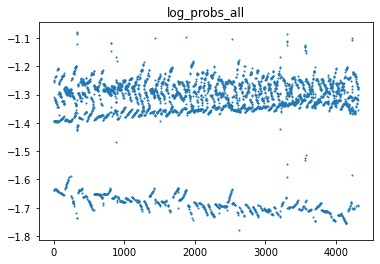

In [16]:
plt.plot(log_probs_all, 'o', markersize=1)
plt.title("log_probs_all")
plt.show()

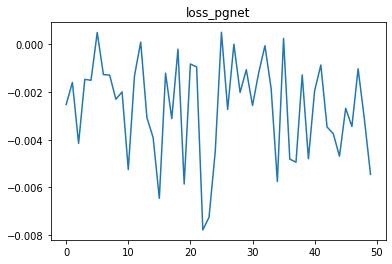

In [17]:
plt.plot(loss_pgnet)
plt.title("loss_pgnet")
plt.show()

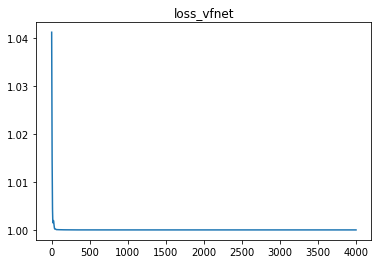

In [18]:
plt.plot(loss_vfnet)
plt.title("loss_vfnet")
plt.show()

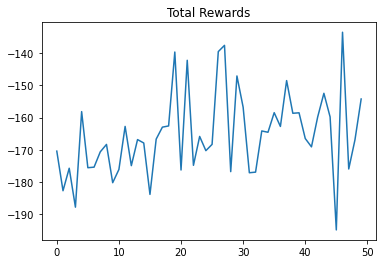

In [19]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

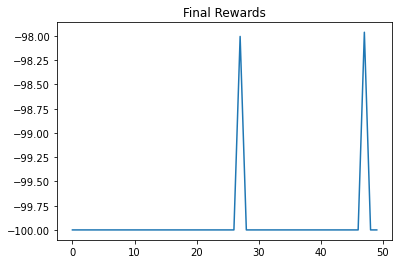

In [20]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

### Test

In [21]:
'''
# 測試前先將 network 切換為 evaluation 模式
agent.pgnet.eval()
agent.vfnet.eval()

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
'''

"\n# 測試前先將 network 切換為 evaluation 模式\nagent.pgnet.eval()\nagent.vfnet.eval()\n\nstate = env.reset()\n\nimg = plt.imshow(env.render(mode='rgb_array'))\n\ntotal_reward = 0\n\ndone = False\nwhile not done:\n    action, _ = agent.sample(state)\n    state, reward, done, _ = env.step(action)\n\n    total_reward += reward\n\n    img.set_data(env.render(mode='rgb_array'))\n    display.display(plt.gcf())\n    display.clear_output(wait=True)\n"

In [22]:
#print(total_reward)

## Discussion

### Questions

1. Why normalization is important?
2. How to determine $\gamma$ for computing the discounted rewards?

### To Do

1. Put the computation of learn_vfnet() into GPU
2. Speedup by implementing OpenMPI